# Dual Momentum

Description

In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import historic_cdi, historic_imab5, historic_sp500, STAR_DATE, END_DATE

### Importando os dados

In [29]:
IBOV = yf.Ticker('^BVSP')

ibov_prices = IBOV.history(start=STAR_DATE, end=END_DATE)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

In [30]:
cdi = historic_cdi(start=STAR_DATE, end=END_DATE)
imab5 = historic_imab5(start=STAR_DATE, end=END_DATE)
sp500_prices = historic_sp500(start=STAR_DATE, end=END_DATE, brl=True)

In [31]:
prices = pd.concat([cdi, imab5, ibov_prices, sp500_prices], keys=['CDI', 'IMA-B 5', 'IBOV', 'SP500 BRL'], join='outer', axis=1)
prices = (prices / prices.iloc[0])
prices = prices.dropna()

prices

,CDI,IMA-B 5,IBOV,SP500 BRL
2004-01-02,1.000000,1.000000,1.000000,1.000000
2004-01-05,1.000601,1.000576,1.048429,1.004152
2004-01-06,1.001202,1.001922,1.050390,1.001270
2004-01-07,1.001803,1.003517,1.038984,1.011210
2004-01-08,1.002405,1.007081,1.056672,1.011452
...,...,...,...,...
2024-08-30,8.212193,11.250613,6.059434,9.986100
2024-09-03,8.218644,11.254458,5.985877,9.716471
2024-09-04,8.221871,11.275119,6.064201,9.724193
2024-09-05,8.225100,11.288138,6.081622,9.641519


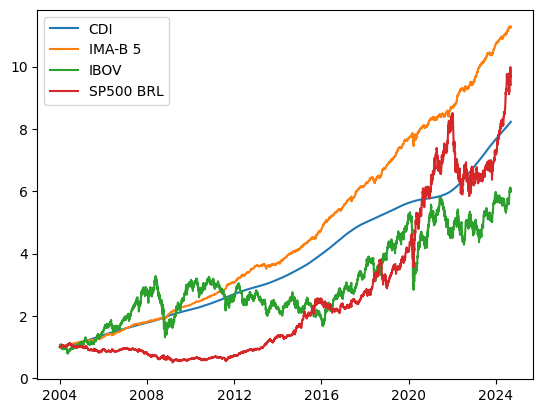

In [32]:
plt.plot(prices)
plt.legend(prices.columns)
plt.show()

In [33]:
ytd_returns = prices.pct_change(periods=252).dropna()

ytd_returns

,CDI,IMA-B 5,IBOV,SP500 BRL
2005-01-18,0.170835,0.183719,0.073246,0.014527
2005-01-19,0.170891,0.183849,0.031404,0.002440
2005-01-20,0.170966,0.182960,0.001442,-0.001142
2005-01-21,0.171042,0.181979,0.021355,-0.025354
2005-01-24,0.171117,0.178574,0.020281,-0.036901
...,...,...,...,...
2024-08-30,0.117454,0.080263,0.182829,0.467453
2024-09-03,0.117784,0.080597,0.164147,0.430686
2024-09-04,0.117675,0.083827,0.189480,0.418531
2024-09-05,0.117566,0.084613,0.175161,0.422258


In [34]:
time_series = pd.to_datetime(ytd_returns.index).to_series()
first_trading_day = time_series.groupby(time_series.index.to_period('M')).apply(lambda x: x == x.min())

ytd_returns.loc[first_trading_day.values]

,CDI,IMA-B 5,IBOV,SP500 BRL
2005-01-18,0.170835,0.183719,0.073246,0.014527
2005-02-01,0.172278,0.168021,0.051694,-0.023893
2005-03-01,0.173851,0.146242,0.250733,-0.058704
2005-04-01,0.175502,0.141318,0.238791,-0.033230
2005-05-02,0.178067,0.144570,0.107252,-0.105415
...,...,...,...,...
2024-05-02,0.128185,0.088211,0.199083,0.263419
2024-06-03,0.126073,0.091150,0.114855,0.343807
2024-07-01,0.123483,0.087676,0.046108,0.433863
2024-08-01,0.119943,0.090874,0.083733,0.408701


In [35]:
conditions = [
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['CDI']) & (ytd_returns['IBOV'] > ytd_returns['SP500 BRL']),
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['CDI']) & (ytd_returns['IBOV'] <= ytd_returns['SP500 BRL']),
    first_trading_day.values & (ytd_returns['IBOV'] <= ytd_returns['CDI']),
]

cases = ['IBOV', 'SP500 BRL', 'IMA-B 5']

ytd_returns['Investment'] = np.select(conditions, cases, default=None)
ytd_returns['Investment'] = ytd_returns['Investment'].ffill()

ytd_returns

,CDI,IMA-B 5,IBOV,SP500 BRL,Investment
2005-01-18,0.170835,0.183719,0.073246,0.014527,IMA-B 5
2005-01-19,0.170891,0.183849,0.031404,0.002440,IMA-B 5
2005-01-20,0.170966,0.182960,0.001442,-0.001142,IMA-B 5
2005-01-21,0.171042,0.181979,0.021355,-0.025354,IMA-B 5
2005-01-24,0.171117,0.178574,0.020281,-0.036901,IMA-B 5
...,...,...,...,...,...
2024-08-30,0.117454,0.080263,0.182829,0.467453,IMA-B 5
2024-09-03,0.117784,0.080597,0.164147,0.430686,SP500 BRL
2024-09-04,0.117675,0.083827,0.189480,0.418531,SP500 BRL
2024-09-05,0.117566,0.084613,0.175161,0.422258,SP500 BRL


In [36]:
ytd_returns['Investment'].value_counts(normalize=True).round(2)

Investment
IMA-B 5      0.50
IBOV         0.38
SP500 BRL    0.11
Name: proportion, dtype: float64

In [37]:
dual_momentum = prices.pct_change().join(ytd_returns[['Investment']], how='right')

dual_momentum

,CDI,IMA-B 5,IBOV,SP500 BRL,Investment
2005-01-18,0.001297,0.001422,-0.033502,0.012099,IMA-B 5
2005-01-19,0.000649,0.000685,0.007555,-0.007811,IMA-B 5
2005-01-20,0.000665,0.000594,-0.027234,-0.006433,IMA-B 5
2005-01-21,0.000665,0.000761,0.008810,-0.014554,IMA-B 5
2005-01-24,0.000665,0.000660,0.015954,-0.011611,IMA-B 5
...,...,...,...,...,...
2024-08-30,0.000393,0.000574,-0.000272,0.013749,IMA-B 5
2024-09-03,0.000786,0.000342,-0.012139,-0.027000,SP500 BRL
2024-09-04,0.000393,0.001836,0.013085,0.000795,SP500 BRL
2024-09-05,0.000393,0.001155,0.002873,-0.008502,SP500 BRL


In [38]:
dual_momentum['Dual Momentum'] = dual_momentum.apply(lambda row: row[row['Investment']], axis=1)
dual_momentum = dual_momentum.drop(columns=['Investment'])

dual_momentum

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2005-01-18,0.001297,0.001422,-0.033502,0.012099,0.001422
2005-01-19,0.000649,0.000685,0.007555,-0.007811,0.000685
2005-01-20,0.000665,0.000594,-0.027234,-0.006433,0.000594
2005-01-21,0.000665,0.000761,0.008810,-0.014554,0.000761
2005-01-24,0.000665,0.000660,0.015954,-0.011611,0.000660
...,...,...,...,...,...
2024-08-30,0.000393,0.000574,-0.000272,0.013749,0.000574
2024-09-03,0.000786,0.000342,-0.012139,-0.027000,-0.027000
2024-09-04,0.000393,0.001836,0.013085,0.000795,0.000795
2024-09-05,0.000393,0.001155,0.002873,-0.008502,-0.008502


In [39]:
dual_momentum_eval = (1 + dual_momentum).cumprod()
dual_momentum_eval = (dual_momentum_eval / dual_momentum_eval.iloc[0]) - 1

dual_momentum_eval

,CDI,IMA-B 5,IBOV,SP500 BRL,Dual Momentum
2005-01-18,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-19,0.000649,0.000685,0.007555,-0.007811,0.000685
2005-01-20,0.001314,0.001280,-0.019885,-0.014194,0.001280
2005-01-21,0.001980,0.002042,-0.011250,-0.028541,0.002042
2005-01-24,0.002646,0.002704,0.004525,-0.039820,0.002704
...,...,...,...,...,...
2024-08-30,6.013964,8.504461,4.645896,8.843112,16.567723
2024-09-03,6.019473,8.507709,4.577359,8.577344,16.093387
2024-09-04,6.022230,8.525164,4.650338,8.584955,16.106972
2024-09-05,6.024988,8.536162,4.666570,8.503465,15.961531


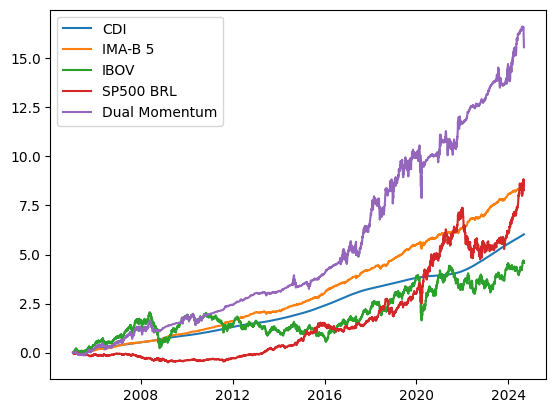

In [40]:
plt.plot(dual_momentum_eval)
plt.legend(dual_momentum_eval.columns)
plt.show()

In [41]:
dual_momentum_eval = dual_momentum_eval + 1
dual_momentum_eval.index = pd.to_datetime(dual_momentum_eval.index)

series_start = dual_momentum_eval.index.min()
series_end = dual_momentum_eval.index.max()

years = (series_end - series_start).days / 365.25

avg_return = (dual_momentum_eval.iloc[-1] / (dual_momentum_eval.iloc[0])) ** (1 / years) - 1
avg_vol = dual_momentum.std() * (252 ** 0.5)

In [42]:
total_results = pd.concat([avg_return, avg_vol], keys=['Avg Return', 'Avg Vol'], axis=1)
total_results['Sharpe Ratio'] = (total_results['Avg Return'] - 0.10) / total_results['Avg Vol']

total_results

,Avg Return,Avg Vol,Sharpe Ratio
CDI,0.104414,0.002702,1.633534
IMA-B 5,0.121716,0.029029,0.748059
IBOV,0.091578,0.268606,-0.031354
SP500 BRL,0.120173,0.212045,0.095137
Dual Momentum,0.153717,0.164790,0.325976
